# Two types of subreddits

Junita Sirait

For case study purposes

In [1]:
import json
import csv
import pandas as pd
import numpy as np
import statistics

import tldextract

from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn import preprocessing

from sklearn.metrics import silhouette_score
from kneed import KneeLocator

from scipy.interpolate import make_interp_spline, BSpline

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

import math

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold

import os

<a id="sub1"></a>
## Subreddit data

In [2]:
pd = os.path.split(os.getcwd())[0]
data_fp = os.path.join(pd,"data/gm-newssources-subreddits")
dfp = os.path.join(pd,"data")
mbfc_path = os.path.join(pd, "data/mbfc")

In [3]:
with open (os.path.join(dfp,"gm_intersection.json"), "r", encoding = "utf-8") as infile:
    gm_intersection = json.load(infile)

In [4]:
len(gm_intersection)

42477

In [5]:
# Reading in all the subreddits in our files

with open(os.path.join(data_fp,"subreddit_ns_2021-01.json"), "r", encoding = "utf-8") as infile1a:
    subreddit_ns_jan = json.load(infile1a)

with open(os.path.join(data_fp,"subreddit_ns_2021-02.json"), "r", encoding = "utf-8") as infile2a:
    subreddit_ns_feb = json.load(infile2a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-03.json"), "r", encoding = "utf-8") as infile3a:
    subreddit_ns_march = json.load(infile3a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-04.json"), "r", encoding = "utf-8") as infile4a:
    subreddit_ns_april = json.load(infile4a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-05.json"), "r", encoding = "utf-8") as infile5a:
    subreddit_ns_may = json.load(infile5a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-06.json"), "r", encoding = "utf-8") as infile6a:
    subreddit_ns_jun = json.load(infile6a)

In [6]:
# ns_subreddit
with open(os.path.join(data_fp,"ns_subreddit_2021-01.json")) as infile1:
    ns_subreddit_01 = json.load(infile1)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-02.json")) as infile2:
    ns_subreddit_02 = json.load(infile2)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-03.json")) as infile3:
    ns_subreddit_03 = json.load(infile3)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-04.json")) as infile4:
    ns_subreddit_04 = json.load(infile4)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-05.json")) as infile5:
    ns_subreddit_05 = json.load(infile5)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-06.json")) as infile6:
    ns_subreddit_06 = json.load(infile6)

## Choosing subreddits

In [26]:
subreddit_labels = csv.DictReader(open("subredditLabels.csv", "r", encoding="utf-8"))

In [27]:
subredditLabels = dict()

for k in subreddit_labels:
    s = k['subreddit']
    l = k['label'].strip()
    subredditLabels[s] = l

In [29]:
Counter(subredditLabels.values())

Counter({'entertainment': 279,
         'hobby': 69,
         'academia': 17,
         'news_politics': 21,
         'basic_inquiry': 14,
         'other': 22,
         'advice': 23,
         'technology': 29,
         'cultural': 11,
         'covid': 1,
         'adult': 12,
         'self-development': 1,
         'self_development': 1})

In [30]:
# let's focus on news_politics and technology

In [33]:
news_politics = [k for k in subredditLabels if subredditLabels[k] == 'news_politics']
technology = [k for k in subredditLabels if subredditLabels[k] == 'technology']

## Let's only use subreddits in `news_politics` and `technology` for this case study

In [34]:
news_tech = news_politics + technology # combination

In [35]:
# filtering all files
subreddit_ns_jan = {k: subreddit_ns_jan[k] for k in subreddit_ns_jan.keys() & set(news_tech)}
subreddit_ns_feb = {k: subreddit_ns_feb[k] for k in subreddit_ns_feb.keys() & set(news_tech)}
subreddit_ns_march = {k: subreddit_ns_march[k] for k in subreddit_ns_march.keys() & set(news_tech)}
subreddit_ns_april = {k: subreddit_ns_april[k] for k in subreddit_ns_april.keys() & set(news_tech)}
subreddit_ns_may = {k: subreddit_ns_may[k] for k in subreddit_ns_may.keys() & set(news_tech)}
subreddit_ns_jun = {k: subreddit_ns_jun[k] for k in subreddit_ns_jun.keys() & set(news_tech)}

In [36]:
files_sub = [subreddit_ns_jan, subreddit_ns_feb, subreddit_ns_march, subreddit_ns_april, subreddit_ns_may, subreddit_ns_jun]
files_ns = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]

In [38]:
sr_union_old = (
      set(subreddit_ns_jan) | set(subreddit_ns_feb) |
      set(subreddit_ns_march) | set(subreddit_ns_april) |
      set(subreddit_ns_may) | set(subreddit_ns_jun))

In [39]:
len(sr_union_old)

50

In [40]:
len(news_tech)

50

Removing "reddit.com" and non_news from files_sub

In [41]:
non_news = []
with open("non_news.csv", "r", encoding="utf-8") as nn:
    r = csv.reader(nn, delimiter=",")
    counter = 0
    for row in r:
        if counter != 0:
            non_news.append(row[0])
        counter += 1
len(non_news)

133

In [42]:
for f in files_sub:
    for n in f:
        if 'reddit.com' in f[n]: f[n].pop('reddit.com')
        # removing each of the non_news
        for nns in non_news:
            if nns in f[n]: f[n].pop(nns)
    print("Done for a file")

Done for a file
Done for a file
Done for a file
Done for a file
Done for a file
Done for a file


Now that we have removed non_news from various subreddits, there would be subreddits that now does not have anything inside. Let's get rid of these subreddits as well.

In [43]:
files_sub = [subreddit_ns_jan, subreddit_ns_feb, subreddit_ns_march, subreddit_ns_april, subreddit_ns_may, subreddit_ns_jun]
files_ns = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]

In [44]:
for s in files_sub:
    empty_subs = set()
    for k in s:
        if len(s[k]) == 0: empty_subs.add(k)
    print(len(empty_subs))
    [s.pop(u) for u in empty_subs]
    print("done for a file")

0
done for a file
1
done for a file
1
done for a file
0
done for a file
1
done for a file
1
done for a file


In [45]:
for f in files_sub:
    [f.pop(u) for u in empty_subs if u in f]
    print("done for a file")

done for a file
done for a file
done for a file
done for a file
done for a file
done for a file


Instead of removing from files_ns, I will reconstruct files_ns from files_sub.

In [46]:
def ns_from_sub(subfile):
    d = defaultdict(dict)
    for sub in subfile:
        for n in subfile[sub]:
            d[n][sub] = subfile[sub][n]
    return d

In [47]:
ns_subreddit_01 = ns_from_sub(subreddit_ns_jan)
ns_subreddit_02 = ns_from_sub(subreddit_ns_feb)
ns_subreddit_03 = ns_from_sub(subreddit_ns_march)
ns_subreddit_04 = ns_from_sub(subreddit_ns_april)
ns_subreddit_05 = ns_from_sub(subreddit_ns_may)
ns_subreddit_06 = ns_from_sub(subreddit_ns_jun)

In [48]:
"reddit.com" in ns_subreddit_01

False

Let's use the intersection in an alphabetical order as a fixed order of our subreddits.

In [49]:
subs = sorted(set(subreddit_ns_jan) & set(subreddit_ns_feb) &
      set(subreddit_ns_march) & set(subreddit_ns_april) &
      set(subreddit_ns_may) & set(subreddit_ns_jun))

In [50]:
len(subs)

48

## Intersections and unions of subreddits

In [51]:
# what about their intersection?
sr_intersection = (
      set(subreddit_ns_jan) & set(subreddit_ns_feb) &
      set(subreddit_ns_march) & set(subreddit_ns_april) &
      set(subreddit_ns_may) & set(subreddit_ns_jun))

print("intersection:", len(sr_intersection))

intersection: 48


In [52]:
sr_union = (
      set(subreddit_ns_jan) | set(subreddit_ns_feb) |
      set(subreddit_ns_march) | set(subreddit_ns_april) |
      set(subreddit_ns_may) | set(subreddit_ns_jun))

print("union:", len(sr_union))

union: 49


<a id="sub2"></a>
## News sources data

How many news sources are there?

In [53]:
# union
ns_union = (set(ns_subreddit_01) |
       set(ns_subreddit_02) |
       set(ns_subreddit_03) |
       set(ns_subreddit_04) |
       set(ns_subreddit_05) |
       set(ns_subreddit_06))

len(ns_union)

7628

In [54]:
nss = (set(ns_subreddit_01) &
       set(ns_subreddit_02) &
       set(ns_subreddit_03) &
       set(ns_subreddit_04) &
       set(ns_subreddit_05) &
       set(ns_subreddit_06))

In [55]:
num_ns = len(nss)
num_ns

1349

## For each news source, let's count in how many subreddits they appear

In [56]:
subreddit_count = dict()
for ns in ns_union:
    subreddit_count[ns] = len(set(ns_subreddit_01.get(ns, dict()).keys()) 
                               | set(ns_subreddit_02.get(ns, dict()).keys()) 
                               | set(ns_subreddit_03.get(ns, dict()).keys()) 
                               | set(ns_subreddit_04.get(ns, dict()).keys())
                               | set(ns_subreddit_05.get(ns, dict()).keys()) 
                               | set(ns_subreddit_06.get(ns, dict()).keys()))

`subreddit_count` stores in how many subreddits each news source appears.

In [57]:
subreddit_count['nytimes.com']

42

In [58]:
subreddit_count_freq = dict(Counter(subreddit_count.values()).most_common())
subreddit_count_freq

{1: 3458,
 2: 1477,
 3: 857,
 4: 491,
 5: 356,
 6: 215,
 7: 143,
 8: 124,
 9: 85,
 10: 84,
 11: 59,
 13: 35,
 12: 33,
 15: 30,
 14: 28,
 16: 28,
 17: 21,
 20: 17,
 18: 15,
 19: 11,
 23: 10,
 22: 7,
 21: 6,
 28: 5,
 31: 4,
 24: 4,
 25: 3,
 32: 3,
 35: 3,
 29: 3,
 26: 3,
 30: 3,
 37: 3,
 42: 1,
 34: 1,
 27: 1,
 39: 1}

`subreddit_count_freq` keeps track of how many news sources appear in *n* subreddits for all possible *n*.

In [59]:
max(subreddit_count_freq.keys())

42

In [60]:
sde_ranked = Counter(subreddit_count).most_common()

for t in sde_ranked[:20]:
    sr, co = t
    if co > 1:
        print(f"{sr} is mentioned in {co} subreddits.")

nytimes.com is mentioned in 42 subreddits.
theverge.com is mentioned in 39 subreddits.
arstechnica.com is mentioned in 37 subreddits.
cnn.com is mentioned in 37 subreddits.
businessinsider.com is mentioned in 37 subreddits.
theguardian.com is mentioned in 35 subreddits.
bloomberg.com is mentioned in 35 subreddits.
bbc.com is mentioned in 35 subreddits.
cnet.com is mentioned in 34 subreddits.
cnbc.com is mentioned in 32 subreddits.
forbes.com is mentioned in 32 subreddits.
vice.com is mentioned in 32 subreddits.
engadget.com is mentioned in 31 subreddits.
reuters.com is mentioned in 31 subreddits.
wired.com is mentioned in 31 subreddits.
bbc.co.uk is mentioned in 31 subreddits.
wsj.com is mentioned in 30 subreddits.
techcrunch.com is mentioned in 30 subreddits.
washingtonpost.com is mentioned in 30 subreddits.
apnews.com is mentioned in 29 subreddits.


In [61]:
sum(subreddit_count_freq.values()) == len(ns_union)

True

In [62]:
import itertools

In [63]:
scf = list(itertools.chain.from_iterable(itertools.repeat(k,v) for k,v in subreddit_count_freq.items()))

Text(0.5, 1.0, 'number of news sources appearing in x subreddits')

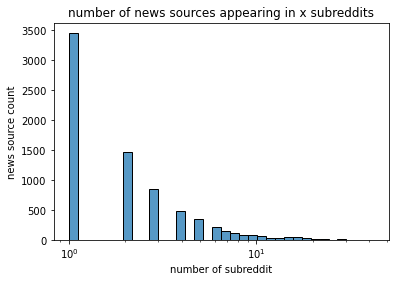

In [64]:
# sns.histplot([math.log(s,10) for s in scf])
sns.histplot(scf, log_scale=True)
plt.xlabel("number of subreddit")
plt.ylabel("news source count")
plt.title("number of news sources appearing in x subreddits")

How many news sources only appear in 10 subreddits or less? what about 9 or 8?

In [69]:
def pct_ns_in_k_subreddits(ks):
    ns_in_i_subreddit = [k for k in subreddit_count if subreddit_count[k] <= ks]
    count = len(ns_in_i_subreddit)
    print("There are {} news sources appearing in only {} subreddits or less ({}%)".format(count, ks, count*100/len(ns_union)))
    return count/len(ns_union)

In [70]:
pct_ns_in_k_subreddits(5)

There are 6639 news sources appearing in only 5 subreddits or less (87.03460933403251%)


0.8703460933403251

In [71]:
0.15*len(ns_union)

1144.2

In [72]:
pct_in_k_subreddits = [(i, pct_ns_in_k_subreddits(i)) for i in range(1000)]

There are 0 news sources appearing in only 0 subreddits or less (0.0%)
There are 3458 news sources appearing in only 1 subreddits or less (45.33298374410068%)
There are 4935 news sources appearing in only 2 subreddits or less (64.69585736759308%)
There are 5792 news sources appearing in only 3 subreddits or less (75.93078133193498%)
There are 6283 news sources appearing in only 4 subreddits or less (82.3675930781332%)
There are 6639 news sources appearing in only 5 subreddits or less (87.03460933403251%)
There are 6854 news sources appearing in only 6 subreddits or less (89.85317252228631%)
There are 6997 news sources appearing in only 7 subreddits or less (91.7278447823807%)
There are 7121 news sources appearing in only 8 subreddits or less (93.3534347142108%)
There are 7206 news sources appearing in only 9 subreddits or less (94.46775039328789%)
There are 7290 news sources appearing in only 10 subreddits or less (95.56895647614053%)
There are 7349 news sources appearing in only 11 su

There are 7628 news sources appearing in only 112 subreddits or less (100.0%)
There are 7628 news sources appearing in only 113 subreddits or less (100.0%)
There are 7628 news sources appearing in only 114 subreddits or less (100.0%)
There are 7628 news sources appearing in only 115 subreddits or less (100.0%)
There are 7628 news sources appearing in only 116 subreddits or less (100.0%)
There are 7628 news sources appearing in only 117 subreddits or less (100.0%)
There are 7628 news sources appearing in only 118 subreddits or less (100.0%)
There are 7628 news sources appearing in only 119 subreddits or less (100.0%)
There are 7628 news sources appearing in only 120 subreddits or less (100.0%)
There are 7628 news sources appearing in only 121 subreddits or less (100.0%)
There are 7628 news sources appearing in only 122 subreddits or less (100.0%)
There are 7628 news sources appearing in only 123 subreddits or less (100.0%)
There are 7628 news sources appearing in only 124 subreddits or 

There are 7628 news sources appearing in only 218 subreddits or less (100.0%)
There are 7628 news sources appearing in only 219 subreddits or less (100.0%)
There are 7628 news sources appearing in only 220 subreddits or less (100.0%)
There are 7628 news sources appearing in only 221 subreddits or less (100.0%)
There are 7628 news sources appearing in only 222 subreddits or less (100.0%)
There are 7628 news sources appearing in only 223 subreddits or less (100.0%)
There are 7628 news sources appearing in only 224 subreddits or less (100.0%)
There are 7628 news sources appearing in only 225 subreddits or less (100.0%)
There are 7628 news sources appearing in only 226 subreddits or less (100.0%)
There are 7628 news sources appearing in only 227 subreddits or less (100.0%)
There are 7628 news sources appearing in only 228 subreddits or less (100.0%)
There are 7628 news sources appearing in only 229 subreddits or less (100.0%)
There are 7628 news sources appearing in only 230 subreddits or 

There are 7628 news sources appearing in only 344 subreddits or less (100.0%)
There are 7628 news sources appearing in only 345 subreddits or less (100.0%)
There are 7628 news sources appearing in only 346 subreddits or less (100.0%)
There are 7628 news sources appearing in only 347 subreddits or less (100.0%)
There are 7628 news sources appearing in only 348 subreddits or less (100.0%)
There are 7628 news sources appearing in only 349 subreddits or less (100.0%)
There are 7628 news sources appearing in only 350 subreddits or less (100.0%)
There are 7628 news sources appearing in only 351 subreddits or less (100.0%)
There are 7628 news sources appearing in only 352 subreddits or less (100.0%)
There are 7628 news sources appearing in only 353 subreddits or less (100.0%)
There are 7628 news sources appearing in only 354 subreddits or less (100.0%)
There are 7628 news sources appearing in only 355 subreddits or less (100.0%)
There are 7628 news sources appearing in only 356 subreddits or 

There are 7628 news sources appearing in only 556 subreddits or less (100.0%)
There are 7628 news sources appearing in only 557 subreddits or less (100.0%)
There are 7628 news sources appearing in only 558 subreddits or less (100.0%)
There are 7628 news sources appearing in only 559 subreddits or less (100.0%)
There are 7628 news sources appearing in only 560 subreddits or less (100.0%)
There are 7628 news sources appearing in only 561 subreddits or less (100.0%)
There are 7628 news sources appearing in only 562 subreddits or less (100.0%)
There are 7628 news sources appearing in only 563 subreddits or less (100.0%)
There are 7628 news sources appearing in only 564 subreddits or less (100.0%)
There are 7628 news sources appearing in only 565 subreddits or less (100.0%)
There are 7628 news sources appearing in only 566 subreddits or less (100.0%)
There are 7628 news sources appearing in only 567 subreddits or less (100.0%)
There are 7628 news sources appearing in only 568 subreddits or 

There are 7628 news sources appearing in only 747 subreddits or less (100.0%)
There are 7628 news sources appearing in only 748 subreddits or less (100.0%)
There are 7628 news sources appearing in only 749 subreddits or less (100.0%)
There are 7628 news sources appearing in only 750 subreddits or less (100.0%)
There are 7628 news sources appearing in only 751 subreddits or less (100.0%)
There are 7628 news sources appearing in only 752 subreddits or less (100.0%)
There are 7628 news sources appearing in only 753 subreddits or less (100.0%)
There are 7628 news sources appearing in only 754 subreddits or less (100.0%)
There are 7628 news sources appearing in only 755 subreddits or less (100.0%)
There are 7628 news sources appearing in only 756 subreddits or less (100.0%)
There are 7628 news sources appearing in only 757 subreddits or less (100.0%)
There are 7628 news sources appearing in only 758 subreddits or less (100.0%)
There are 7628 news sources appearing in only 759 subreddits or 

There are 7628 news sources appearing in only 872 subreddits or less (100.0%)
There are 7628 news sources appearing in only 873 subreddits or less (100.0%)
There are 7628 news sources appearing in only 874 subreddits or less (100.0%)
There are 7628 news sources appearing in only 875 subreddits or less (100.0%)
There are 7628 news sources appearing in only 876 subreddits or less (100.0%)
There are 7628 news sources appearing in only 877 subreddits or less (100.0%)
There are 7628 news sources appearing in only 878 subreddits or less (100.0%)
There are 7628 news sources appearing in only 879 subreddits or less (100.0%)
There are 7628 news sources appearing in only 880 subreddits or less (100.0%)
There are 7628 news sources appearing in only 881 subreddits or less (100.0%)
There are 7628 news sources appearing in only 882 subreddits or less (100.0%)
There are 7628 news sources appearing in only 883 subreddits or less (100.0%)
There are 7628 news sources appearing in only 884 subreddits or 

[(0.0, 80.0)]

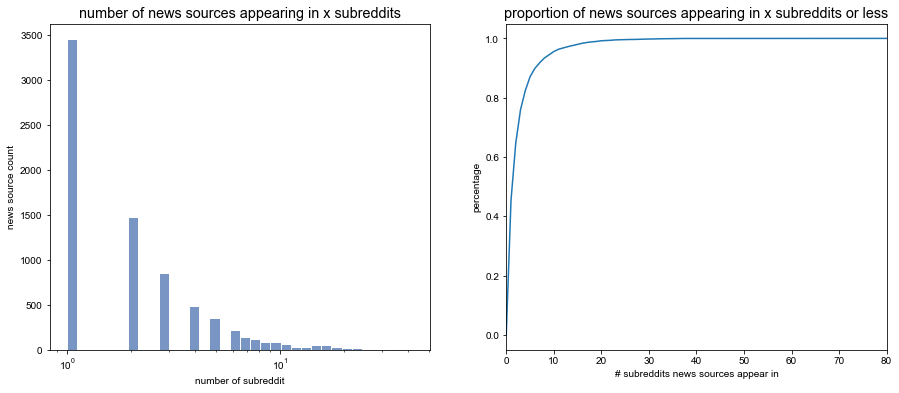

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
sns.set(font_scale = 1.2)

sns.histplot(scf, log_scale=True, ax=ax1)
ax1.set_xlabel("number of subreddit")
ax1.set_ylabel("news source count")
ax1.set_title("number of news sources appearing in x subreddits")

sns.lineplot(x=[k[0] for k in pct_in_k_subreddits],
             y=[k[1] for k in pct_in_k_subreddits],
            ax=ax2)
ax2.set_ylabel("percentage")
ax2.set_xlabel("# subreddits news sources appear in")
ax2.set_title("proportion of news sources appearing in x subreddits or less")
ax2.set(xlim = (0, 80))

In [74]:
# mean
statistics.mean(scf)

3.046014682747771

In [75]:
# median
statistics.median(scf)

2.0

## For each news source let's count how many times they are shared regardless of in which subreddits

In [76]:
sum(dict().values())

0

In [77]:
def get_mention_count(ns):
    """get total mention count of ns in all six months"""
    count = 0
    files = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]
    for f in files:
        ns_dict = f.get(ns, dict())
        if len(ns_dict) > 0:
            mentions = sum([m[0] for m in ns_dict.values()])
            count += mentions
    return count

In [78]:
mention_count = dict()
for ns in ns_union:
    mention_count[ns] = get_mention_count(ns)

In [79]:
statistics.mean(mention_count.values())

48.47600943890928

In [80]:
statistics.stdev(mention_count.values())

435.9017377555756

In [81]:
statistics.median(mention_count.values())

3.0

In [82]:
len(mention_count)

7628

In [83]:
Counter(mention_count).most_common(20)

[('reuters.com', 16765),
 ('cnn.com', 15244),
 ('theguardian.com', 11268),
 ('thehill.com', 10834),
 ('nytimes.com', 8978),
 ('apnews.com', 8620),
 ('washingtonpost.com', 7948),
 ('bbc.com', 6878),
 ('independent.co.uk', 6874),
 ('businessinsider.com', 6014),
 ('cnbc.com', 5521),
 ('nbcnews.com', 5176),
 ('cbc.ca', 4809),
 ('politico.com', 4604),
 ('newsweek.com', 4359),
 ('bloomberg.com', 3900),
 ('msn.com', 3774),
 ('bbc.co.uk', 3729),
 ('aljazeera.com', 3441),
 ('npr.org', 3219)]

In [84]:
news_ge10k = [m for m in mention_count if mention_count[m] >= 1000]
len(news_ge10k)

59

<AxesSubplot:ylabel='Count'>

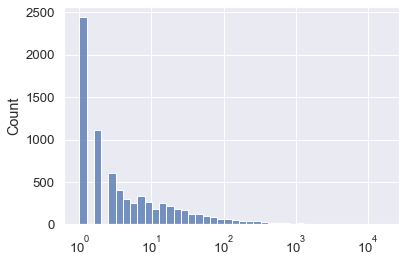

In [85]:
sns.histplot(list(mention_count.values()), log_scale=True)

<AxesSubplot:ylabel='Count'>

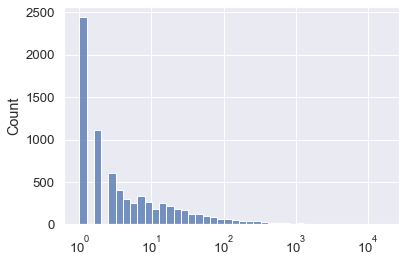

In [86]:
sns.histplot(list([k for k in mention_count.values() if k <100000]), log_scale=True)

In [87]:
len([k for k in mention_count.values() if k <5])*100/len(mention_count)

59.77975878342947

In [88]:
(1-0.35)*len(mention_count)

4958.2

## For each subreddit let's count how many news sources were mentioned in it

Counting how many news sources were mentioned in each subreddit

In [89]:
nsc_count = dict()
for sr in sr_union:
    nsc_count[sr] = len(set(subreddit_ns_jan.get(sr, dict()).keys()) 
                               | set(subreddit_ns_feb.get(sr, dict()).keys()) 
                               | set(subreddit_ns_march.get(sr, dict()).keys()) 
                               | set(subreddit_ns_april.get(sr, dict()).keys())
                               | set(subreddit_ns_may.get(sr, dict()).keys()) 
                               | set(subreddit_ns_jun.get(sr, dict()).keys()))

`nsc_count` stores how many news sources appear in each subreddit.

In [90]:
len([k for k in nsc_count if nsc_count[k]<1])

0

In [91]:
nsc_count_freq = dict(Counter(nsc_count.values()).most_common())
nsc_count_freq

{136: 2,
 140: 2,
 83: 1,
 33: 1,
 111: 1,
 65: 1,
 42: 1,
 1432: 1,
 216: 1,
 130: 1,
 27: 1,
 94: 1,
 222: 1,
 99: 1,
 339: 1,
 537: 1,
 150: 1,
 200: 1,
 6: 1,
 58: 1,
 1542: 1,
 106: 1,
 231: 1,
 1523: 1,
 517: 1,
 682: 1,
 20: 1,
 128: 1,
 1199: 1,
 34: 1,
 2564: 1,
 529: 1,
 86: 1,
 208: 1,
 284: 1,
 603: 1,
 239: 1,
 274: 1,
 137: 1,
 43: 1,
 3043: 1,
 54: 1,
 478: 1,
 73: 1,
 1073: 1,
 725: 1,
 2444: 1}

`nsc_count_freq` keeps track of how many news sources appear in *n* subreddits for all possible *n*.

In [92]:
max(nsc_count_freq.keys())

3043

In [93]:
nsc_ranked = Counter(nsc_count).most_common()

for t in nsc_ranked:
    sr, co = t
    if co >= 80:
        print(f"{sr} has {co} news sources mentioned in it.")

politics has 3043 news sources mentioned in it.
worldnews has 2564 news sources mentioned in it.
nottheonion has 2444 news sources mentioned in it.
CryptoCurrency has 1542 news sources mentioned in it.
technology has 1523 news sources mentioned in it.
europe has 1432 news sources mentioned in it.
UpliftingNews has 1199 news sources mentioned in it.
Futurology has 1073 news sources mentioned in it.
canada has 725 news sources mentioned in it.
LateStageCapitalism has 682 news sources mentioned in it.
entertainment has 603 news sources mentioned in it.
stocks has 537 news sources mentioned in it.
Health has 529 news sources mentioned in it.
space has 517 news sources mentioned in it.
privacy has 478 news sources mentioned in it.
apple has 339 news sources mentioned in it.
JusticeServed has 284 news sources mentioned in it.
changemyview has 274 news sources mentioned in it.
hardware has 239 news sources mentioned in it.
gadgets has 231 news sources mentioned in it.
Android has 222 news sou

In [94]:
sum(nsc_count_freq.values()) == len(sr_union)

True

In [95]:
import itertools

In [96]:
nsc = list(itertools.chain.from_iterable(itertools.repeat(k,v) for k,v in nsc_count_freq.items()))

Text(0.5, 1.0, 'number of subreddits with x news sources')

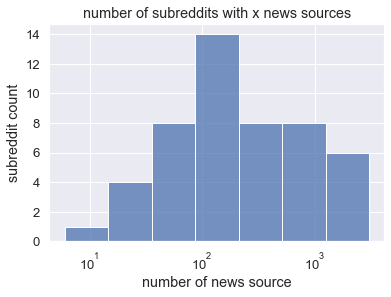

In [97]:
sns.histplot(nsc, log_scale=True)
plt.xlabel("number of news source")
plt.ylabel("subreddit count")
plt.title("number of subreddits with x news sources")

In [98]:
len([n for n in nsc if n>=20])

48

How many subreddits only mentioned 5 news sources or less?

In [99]:
def pct_subreddits_mentioning_k_newssources(ks):
    sr_mention_i_nsc = [k for k in nsc_count if nsc_count[k] <= ks]
    count = len(sr_mention_i_nsc)
    print("There are {} subreddits mentioning in only {} news sources or less ({}%)".format(count, ks, count/len(sr_union)))
    return count/len(sr_union)

In [100]:
pct_subreddits_mentioning_k_newssources(20)

There are 2 subreddits mentioning in only 20 news sources or less (0.04081632653061224%)


0.04081632653061224

In [101]:
# mean
statistics.mean(nsc)

474.18367346938777

In [102]:
# median
statistics.median(nsc)

150

## For each subreddit let's count total submissions that are news source related

In [103]:
def get_submission_count(sb):
    """get total mention count of ns in all six months"""
    count = 0
    files = [subreddit_ns_jan, subreddit_ns_feb, subreddit_ns_march, subreddit_ns_april, subreddit_ns_may, subreddit_ns_jun]
    for f in files:
        sb_dict = f.get(sb, dict())
        if len(sb_dict) > 0:
            mentions = sum([m[0] for m in sb_dict.values()])
            count += mentions
    return count

In [104]:
mention_count = dict()
for sb in sr_union:
    mention_count[sb] = get_submission_count(sb)

In [105]:
statistics.mean(mention_count.values())

7546.428571428572

In [106]:
statistics.stdev(mention_count.values())

22048.251678610108

In [107]:
statistics.median(mention_count.values())

647

In [108]:
len(mention_count)

49

In [109]:
Counter(mention_count).most_common(20)

[('politics', 136899),
 ('worldnews', 68589),
 ('nottheonion', 29538),
 ('CryptoCurrency', 28692),
 ('europe', 17135),
 ('technology', 16257),
 ('canada', 14449),
 ('Futurology', 6753),
 ('UpliftingNews', 5774),
 ('entertainment', 5360),
 ('space', 4841),
 ('stocks', 4442),
 ('buildapc', 3728),
 ('Health', 3612),
 ('apple', 3445),
 ('LateStageCapitalism', 2872),
 ('privacy', 2270),
 ('Android', 1969),
 ('hardware', 1482),
 ('gadgets', 1127)]

In [110]:
ns_subreddit_01['cbc.ca']

{'technology': [9, 7.18, 36],
 'space': [4, 2.59, 65],
 'LateStageCapitalism': [5, 3.9399999999999995, 11],
 'UpliftingNews': [17, 15.39, 107],
 'worldnews': [153, 130.94, 18318],
 'canada': [532, 420.6200000000006, 26421],
 'europe': [1, 0.87, 1],
 'aviation': [1, 1.0, 0],
 'JusticeServed': [1, 1.0, 1],
 'Android': [1, 0.75, 97],
 'politics': [121, 107.37999999999998, 227661],
 'stocks': [1, 0.94, 4404],
 'apple': [1, 0.78, 30],
 'privacy': [4, 3.78, 1],
 'Futurology': [3, 2.9299999999999997, 128],
 'nottheonion': [41, 33.17, 1260]}

<AxesSubplot:ylabel='Count'>

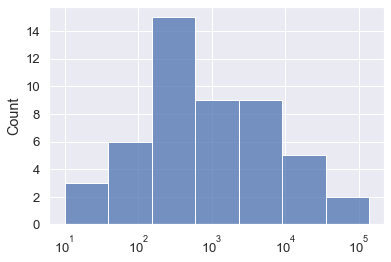

In [111]:
sns.histplot(list(mention_count.values()), log_scale=True)

In [112]:
len([k for k in mention_count.values() if k <5])*100/len(mention_count)

0.0

In [113]:
(1-0.35)*len(mention_count)

31.85

## upvote based weight vs comment based weight 

Do they have correlation?

Let's look at January's data

In [114]:
upvote_based = [ns_subreddit_01[ns][sr][1] for ns in ns_subreddit_01 for sr in ns_subreddit_01[ns]]
comment_based = [ns_subreddit_01[ns][sr][2] for ns in ns_subreddit_01 for sr in ns_subreddit_01[ns]]
unweighted = [ns_subreddit_01[ns][sr][0] for ns in ns_subreddit_01 for sr in ns_subreddit_01[ns]]

Text(0, 0.5, 'upvote_based')

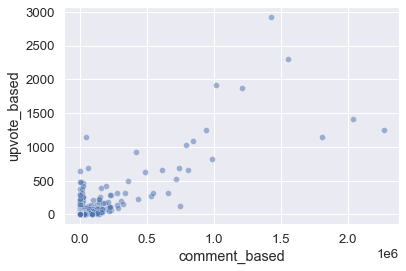

In [115]:
sns.scatterplot(x=comment_based, y=upvote_based, alpha=0.5)
plt.xlabel("comment_based")
plt.ylabel("upvote_based")
# plt.xlim([-100000,4000000])
# plt.ylim([-5000,150000])

Text(0, 0.5, 'upvote_based')

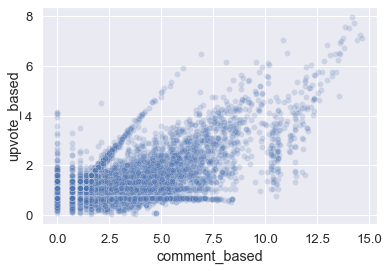

In [116]:
a = sns.scatterplot(x=np.log(np.array([c+1 for c in comment_based])), y=np.log(np.array([u+1 for u in upvote_based])), alpha=0.2)
plt.xlabel("comment_based")
plt.ylabel("upvote_based")

In [117]:
from scipy.stats import pearsonr

In [118]:
corr, _ = pearsonr(np.log(np.array([c+1 for c in comment_based])), np.log(np.array([u+1 for u in upvote_based])))
corr

0.6808066366039508

In [119]:
corr_raw, _ = pearsonr(comment_based, upvote_based)
corr_raw

0.8283519748110515

In [123]:
non_outlier = [n for n in ns_union if subreddit_count[n]>5]
len(non_outlier)

989

In [124]:
# with open("sport_news_non_outlier.json", "w", encoding="utf-8") as s:
#     json.dump(non_outlier, s)

## Cluster Try Out

First, I make a list of subreddits with fixed order, where I only include subreddits where our non_outlier news sources are mentioned in.

In [125]:
len(non_outlier)

989

In [126]:
# subreddits = subs
subreddits = set()
nsr_files = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]
# first, I filter for only the subreddits in which our news sources are mentioned
c = 0
for n in non_outlier:
    subreddits = (subreddits | (set(ns_subreddit_01.get(n, dict()).keys()) 
                               & set(ns_subreddit_02.get(n, dict()).keys()) 
                               & set(ns_subreddit_03.get(n, dict()).keys()) 
                               & set(ns_subreddit_04.get(n, dict()).keys())
                               & set(ns_subreddit_05.get(n, dict()).keys()) 
                               & set(ns_subreddit_06.get(n, dict()).keys())))
    c += 1
    if c%100==0: print(f"done {c}")
subreddits = list(subreddits)
len(subreddits)

done 100
done 200
done 300
done 400
done 500
done 600
done 700
done 800
done 900


40

There are 9195 subreddits.

In [127]:
subreddits[-10:]

['PoliticalDiscussion',
 'google',
 'MachineLearning',
 'MechanicalKeyboards',
 'CryptoCurrency',
 'privacy',
 'mac',
 'Futurology',
 'canada',
 'nottheonion']

If I should order them later, I can do so.

## Incorporating subscribers information

In [128]:
pd1 = os.path.split(os.getcwd())[0]
data_fp = os.path.join(pd1,"data/gm-newssources-subreddits")
dfp = os.path.join(pd1,"data")

In [129]:
sfp = os.path.join(pd1,"data/subreddits")

In [130]:
# Let's only use the subreddits that have lots of subscribers
with open (os.path.join(sfp,"subreddit_subscribers.json"), "r", encoding = "utf-8") as infile:
    subreddit_subscribers = json.load(infile)

In [131]:
subreddit_subscribers['politics']

6201779

In [132]:
len(subreddit_subscribers)

49055

In [133]:
len(subreddits)

40

In [134]:
subreddits_w_subc = [k for k in subreddits if k in subreddit_subscribers]
len(subreddits_w_subc)

40

It seems that there are `None` values, so let's filter those subreddits out.

In [135]:
print([s for s in subreddits_w_subc if subreddit_subscribers[s] is None])

[]


In [136]:
subreddits_w_subc = [s for s in subreddits_w_subc if subreddit_subscribers[s] is not None]

In [137]:
len(subreddits_w_subc)

40

Now, I will sort the 8,294 subreddits based on the # of their subscribers in a descending order.

In [138]:
srs_all = sorted(subreddits_w_subc, key= lambda x: subreddit_subscribers[x], reverse= True)

Text(0.5, 1.0, 'Subreddits Subscribers')

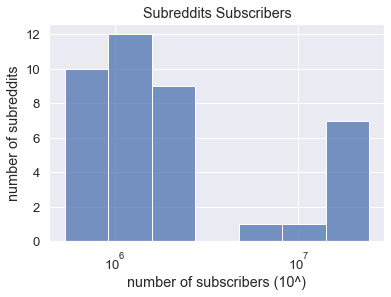

In [139]:
# plt.hist([math.log(subreddit_subscribers[s],10) for s in srs_all if subreddit_subscribers[s] > 0])
sns.histplot([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s]>0], log_scale=True)
# plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])
# plt.yscale("log")
# plt.xscale("log")
plt.ylabel("number of subreddits")
plt.xlabel("number of subscribers (10^)")
plt.title("Subreddits Subscribers")
# log scale for both x and y

Which subreddits are the top three?

In [140]:
print([(s,subreddit_subscribers[s]) for s in srs_all if subreddit_subscribers[s]>10000])

[('worldnews', 24253881), ('nottheonion', 17063313), ('space', 16937271), ('gadgets', 16890685), ('Documentaries', 16293009), ('UpliftingNews', 15926382), ('Futurology', 14675526), ('technology', 9065541), ('politics', 6201779), ('europe', 2414526), ('buildapc', 2364411), ('iphone', 2362255), ('Android', 2240229), ('raspberry_pi', 1883302), ('OutOfTheLoop', 1778369), ('mac', 1704990), ('nintendo', 1685766), ('entertainment', 1591748), ('apple', 1521243), ('learnprogramming', 1496685), ('JusticeServed', 1415105), ('hardware', 1208099), ('hacking', 1160412), ('MachineLearning', 1098702), ('changemyview', 1050711), ('CryptoCurrency', 1036133), ('Health', 1007872), ('google', 985616), ('techsupport', 950173), ('audiophile', 935379), ('PoliticalDiscussion', 852271), ('privacy', 845664), ('stocks', 699563), ('canada', 675822), ('aviation', 619022), ('MechanicalKeyboards', 608580), ('Python', 595969), ('Piracy', 543905), ('LateStageCapitalism', 539379), ('linux', 532170)]


In [141]:
list(subreddit_subscribers.values()).count(None)

25

In [142]:
statistics.median([k for k in list(subreddit_subscribers.values()) if k is not None])

1420.0

In [143]:
statistics.mean([k for k in list(subreddit_subscribers.values()) if k is not None])

50070.832184376915

## Building `ns_repr`

Which will be in the form of feature-based matrix, where each row represents a news source, and columns representing subreddits. 

Idea 1: Each subreddit will be represented by 18 columns: unweighted count, upvote based weighted count, and comment based weighted count for each of the six months that we are interested in. THIS does not work.

Idea 2: Each subreddit will be represented by 3 columns: average unweighted count, average upvote based weighted count, and average comment based weighted count.

In [144]:
srs = srs_all

In [145]:
a = {"a": 1, "b": 2}
b = {"b": 1, "c": 2}
res = {**a, **b}
res

{'a': 1, 'b': 1, 'c': 2}

Idea 1: For each news source, I create a list of length `(18 * # subreddits)`.

Idea 1: For each news source, I create a list of length `(3 * # subreddits)`

Old code
```
# here I will cast the inner dictionaries of ns_subreddits to be Counter so I can avoid a lot of if-else statements
files = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]
for f in files:
    for k in f: # k is each news source
        for ns in f[k]:
            # averaging based on weighted counts
            count, upv, comm = f[k][ns]
            avg = (upv + comm)/count
            f[k][ns] = avg
        f[k] = Counter(f[k])
```

In [146]:
files_sub = [subreddit_ns_jan, subreddit_ns_feb, subreddit_ns_march, subreddit_ns_april, subreddit_ns_may, subreddit_ns_jun]
files_ns = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]

In [147]:
len(non_outlier)

989

In [148]:
len(srs)

40

I tried and found out that using all 23.7k subreddits results in MemoryError. So I should use less

In [149]:
srs = srs_all

For idea 1:

```
ns_sr_rep = defaultdict(list)
default_counter = Counter() # to avoid a lot of if else statements

ncount = 0

# for ns in nss:
for ns in non_outlier:
    # for each news sources, construct the 18*length(subreddits) features
    for f in files_sub:
        for idx in range(len(srs)):
            # making sure the ordering follows `srs` based on subscribers
            ns_sr_rep[ns] += f[ns][srs[idx]][1:] if (ns in f and srs[idx] in f[ns]) else [0, 0]
    ncount += 1
    if ncount%200==0: print(ncount)
```

In [150]:
# For idea 2

ns_sr_rep = defaultdict(list)
default_counter = Counter() # to avoid a lot of if else statements

ncount = 0

# for ns in nss:
for ns in non_outlier:
    # for each news sources, construct the length(subreddits) features
    for idx in range(len(srs)):
        # making sure the ordering follows `srs` based on subscribers
        current_sr = srs[idx]
        # avg_unweighted_counts = sum([ii[current_sr][ns][0] if current_sr in ii and ns in ii[current_sr] else 0 for ii in files_sub])/6
        avg_votebased_counts = sum([ii[current_sr][ns][1] if (current_sr in ii and ns in ii[current_sr]) else 0 for ii in files_sub])/6
        avg_commentbased_counts = sum([ii[current_sr][ns][2] if current_sr in ii and ns in ii[current_sr] else 0 for ii in files_sub])/6
        ns_sr_rep[ns] += [avg_votebased_counts, avg_commentbased_counts]
    ncount += 1
    if ncount%200==0: print(ncount)

200
400
600
800


In [151]:
len(srs)

40

In [152]:
len(non_outlier)

989

    code started at 22:56

Let's see one example of representation for `nytimes.com`.

In [153]:
ns_sr_rep["bbc.co.uk"]

[228.93999999999997,
 11514.833333333334,
 64.68,
 3033.5,
 5.613333333333333,
 443.1666666666667,
 0.3133333333333333,
 85.83333333333333,
 3.2600000000000002,
 9.833333333333334,
 21.083333333333332,
 821.1666666666666,
 3.045,
 304.8333333333333,
 17.37,
 1391.5,
 43.33666666666667,
 51873.333333333336,
 69.72666666666667,
 2879.3333333333335,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0866666666666667,
 54.666666666666664,
 0.0,
 0.0,
 1.7866666666666668,
 93.16666666666667,
 0.0,
 0.0,
 0.2133333333333333,
 3.0,
 4.81,
 154.16666666666666,
 0.9866666666666667,
 84.16666666666667,
 0.0,
 0.0,
 1.9566666666666668,
 35.0,
 0.31,
 20.166666666666668,
 1.1466666666666667,
 26.5,
 0.0,
 0.0,
 2.555,
 377.1666666666667,
 10.285,
 173.33333333333334,
 3.69,
 18.333333333333332,
 0.18833333333333332,
 0.8333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.27,
 18.0,
 2.2800000000000002,
 30.666666666666668,
 1.2066666666666668,
 169.0,
 1.9566666666666668,
 6.833333333333333,
 1.6783333333333335,
 14.666666666666

Let's investigate the sparsity of our data

In [154]:
from numpy import array
from numpy import count_nonzero
from scipy.sparse import csr_matrix

In [155]:
# ns_repr, ns_fixed = np.array([v[1] for v in items]), list([v[0] for v in items]) # this causes memory error
## MemoryError: Unable to allocate 15.3 GiB for an array with shape (11436, 180000) and data type float64
items = ns_sr_rep.items()
ns_repr = np.array([k for k in ns_sr_rep.values()])

In [156]:
ns_repr[:10]

array([[5.51500000e+00, 1.81333333e+02, 1.95800000e+01, 1.98333333e+01,
        3.70333333e+00, 2.83333333e+02, 9.00833333e+00, 2.09183333e+03,
        0.00000000e+00, 0.00000000e+00, 1.55333333e+00, 2.95500000e+02,
        5.48333333e+00, 8.51333333e+02, 2.45816667e+01, 6.34416667e+03,
        1.88283333e+01, 1.93333333e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.60000000e-01, 7.66666667e+00,
        7.01666667e-01, 1.52833333e+02, 3.33333333e-01, 1.50000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e-01, 2.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        2.40166667e+00, 1.60333333e+02, 0.00000000e+00, 0.00000000e+00,
        1.53333333e-01, 6.00000000e+00, 3.00000000e-01, 5.10000000e+01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.93666667e+00, 1.04166667e+02,
        3.33333333e-01, 0.00000000e+00, 4.33333333e-01, 8.333333

In [157]:
sparsity = 1.0 - np.count_nonzero(ns_repr)/ns_repr.size

In [158]:
sparsity

0.7542087967644084

Wow very high sparsity.

In [159]:
len(non_outlier)

989

How many subreddits have all 0's for all news sources?

In [160]:
counter = 0
for ii in range(len(srs)):
    fl = []
    for kk in ns_repr:
        fl.append(kk[ii])
    counter += 1
    print(statistics.median(fl), statistics.mean(fl), statistics.variance(fl), counter)

0.59 8.461730704415237 2398.1376084304475 1
6.0 639.0594876980115 9979813.88953568 2
0.6616666666666667 3.8264914054600605 172.97706454415123 3
2.6666666666666665 156.37967644084935 669925.0848103316 4
0.0 0.5772244691607684 16.33728054492922 5
0.0 29.92298618132794 61387.32511887397 6
0.0 0.1506386922817661 1.1900779345517742 7
0.0 28.457869902258174 51152.93147786925 8
0.0 0.041188068756319515 0.1264682704872809 9
0.0 0.4745534209639366 146.14912127191275 10
0.15 0.7161779575328615 8.02239444153343 11
0.16666666666666666 37.875126390293225 35040.29745310198 12
0.12833333333333333 0.8254668014829795 7.580502433135385 13
0.16666666666666666 84.10043815301651 130750.43130997427 14
0.22999999999999998 1.8898736097067745 61.726916850293634 15
0.6666666666666666 160.1179642736771 750802.6694374171 16
0.6666666666666666 18.068304684866902 8455.674293524315 17
1.0 8211.745028648467 1606035440.231117 18
0.07333333333333333 1.7605426356589147 108.2591659164496 19
0.0 66.45955510616784 169971.5

In [161]:
# convert to sparse matrix (CSR method)
S = csr_matrix(ns_repr)
print(S)

  (0, 0)	5.515
  (0, 1)	181.33333333333334
  (0, 2)	19.580000000000002
  (0, 3)	19.833333333333332
  (0, 4)	3.7033333333333327
  (0, 5)	283.3333333333333
  (0, 6)	9.008333333333333
  (0, 7)	2091.8333333333335
  (0, 10)	1.5533333333333335
  (0, 11)	295.5
  (0, 12)	5.483333333333333
  (0, 13)	851.3333333333334
  (0, 14)	24.581666666666663
  (0, 15)	6344.166666666667
  (0, 16)	18.828333333333333
  (0, 17)	19.333333333333332
  (0, 22)	0.45999999999999996
  (0, 23)	7.666666666666667
  (0, 24)	0.7016666666666667
  (0, 25)	152.83333333333334
  (0, 26)	0.3333333333333333
  (0, 27)	1.5
  (0, 32)	0.09999999999999999
  (0, 33)	2.0
  (0, 34)	1.0
  :	:
  (987, 17)	3059.3333333333335
  (987, 18)	0.15
  (987, 19)	18.166666666666668
  (987, 34)	0.08333333333333333
  (987, 40)	0.15166666666666667
  (987, 41)	9.166666666666666
  (987, 52)	0.105
  (987, 53)	0.3333333333333333
  (987, 76)	0.16666666666666666
  (987, 77)	0.16666666666666666
  (988, 6)	0.16
  (988, 7)	7.166666666666667
  (988, 12)	0.2916666

### Now PCA

In [162]:
print([k for k in ns_repr[21:50]])

[array([1.87166667e+01, 1.92966667e+03, 1.10000000e+01, 1.15000000e+01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00166667e+00, 4.25000000e+02,
       2.28333333e-01, 1.66666667e-01, 1.36000000e+00, 1.41666667e+02,
       8.10333333e+00, 6.24266667e+03, 1.08500000e+00, 3.43333333e+01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.28333333e-01, 3.50000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.20000000e-01, 7.50000000e+00,
       1.65000000e-01, 7.83333333e+00, 0.00000000e+00, 0.00000000e+00,
     

In [163]:
svd = TruncatedSVD(n_components=100) #, n_iter=7, random_state=42)
svd_pca = PCA(n_components=min(len(ns_repr), len(ns_repr[0])))

In [164]:
# fit1 = svd.fit(ns_repr)
# fit1 = svd.fit(csr_matrix(preprocessing.normalize(ns_repr)))
fit1 = svd_pca.fit(StandardScaler().fit_transform(np.array(ns_repr)))

In [165]:
explained_var = fit1.explained_variance_ratio_

In [166]:
explained_var

array([1.94308329e-01, 1.01317449e-01, 5.48494579e-02, 5.11548945e-02,
       3.43263372e-02, 3.20610123e-02, 2.98683029e-02, 2.76039618e-02,
       2.50420219e-02, 2.48680388e-02, 2.40640026e-02, 2.37414426e-02,
       2.22059207e-02, 2.16857309e-02, 2.12185152e-02, 2.10725422e-02,
       1.91041227e-02, 1.85679337e-02, 1.76460998e-02, 1.64385143e-02,
       1.55261773e-02, 1.40891167e-02, 1.35021026e-02, 1.29116185e-02,
       1.25128250e-02, 1.17209274e-02, 1.13893693e-02, 1.02806886e-02,
       9.60456653e-03, 7.37467296e-03, 7.24532232e-03, 6.73442393e-03,
       6.39372346e-03, 6.00721152e-03, 5.70985009e-03, 5.07299702e-03,
       4.75955834e-03, 4.00058553e-03, 3.69204699e-03, 3.62527141e-03,
       3.42447827e-03, 3.18343075e-03, 3.02744871e-03, 2.83465702e-03,
       2.59564856e-03, 2.53520797e-03, 2.39253084e-03, 2.11480498e-03,
       1.91224908e-03, 1.88975255e-03, 1.79728906e-03, 1.67104158e-03,
       1.56919621e-03, 1.44004762e-03, 1.28928351e-03, 1.22939626e-03,
      

In [167]:
len(explained_var)

80

In [168]:
fit1.explained_variance_ratio_.sum()

1.0

In [169]:
explained_var_sums = [sum(explained_var[:d]) for d in range(len(ns_repr))]

In [170]:
explained_var_sums

[0,
 0.19430832889185273,
 0.2956257778373857,
 0.35047523572359296,
 0.4016301301806379,
 0.4359564674149425,
 0.4680174797248433,
 0.49788578265585065,
 0.525489744449262,
 0.5505317663836292,
 0.5753998052193958,
 0.5994638078257777,
 0.6232052504543543,
 0.6454111711811654,
 0.6670969020504961,
 0.6883154172775461,
 0.7093879594320771,
 0.7284920821445041,
 0.7470600158746811,
 0.764706115643399,
 0.7811446299350329,
 0.7966708072818129,
 0.8107599239841008,
 0.8242620265901978,
 0.837173645049205,
 0.8496864700352335,
 0.8614073974509607,
 0.8727967667121447,
 0.8830774552877344,
 0.8926820218194166,
 0.9000566947810056,
 0.9073020170975767,
 0.9140364410284069,
 0.9204301644906803,
 0.9264373760073693,
 0.9321472260987334,
 0.9372202231208722,
 0.9419797814601896,
 0.9459803669935496,
 0.9496724139800722,
 0.9532976853902256,
 0.9567221636625302,
 0.9599055944157332,
 0.962933043124319,
 0.9657677001397342,
 0.9683633487000776,
 0.9708985566728382,
 0.973291087516003,
 0.97540589

(0.0, 80.0)

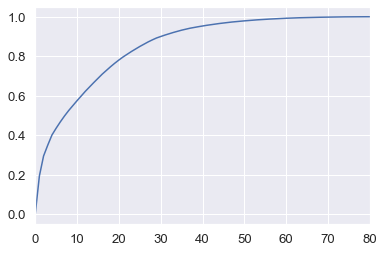

In [174]:
a = sns.lineplot(x=range(len(explained_var_sums)), y=explained_var_sums)
a.set_xlim(0,80)

Now, I will cast those list representation values to be numpy arrays so I can preprocess them easily. Further, I will normalize each array.

*side note: `preprocessing.normalize` vs `standardscaler`*

In [175]:
preprocessing.normalize(np.array([[1,100,2,3],[2,50,100,10]]))

array([[0.00999301, 0.99930073, 0.01998601, 0.02997902],
       [0.01781459, 0.44536472, 0.89072943, 0.08907294]])

In [176]:
scaler = StandardScaler()
scaler.fit_transform(np.array([[1,100,2,3],[2,50,100,10],[2,50,100,10]]))

array([[-1.41421356,  1.41421356, -1.41421356, -1.41421356],
       [ 0.70710678, -0.70710678,  0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678,  0.70710678,  0.70710678]])

Now I'm thinking, should I *normalize* or *standardize*?

In [177]:
# for ns in ns_sr_rep:
#     rep = ns_sr_rep[ns]
#     ns_sr_rep[ns] = preprocessing.normalize(np.array([rep]))

## K-Means

Without and with standardization.

First, I need to find optimum `k`.

In [178]:
ns_repr_new = fit1.transform(StandardScaler().fit_transform(np.array(ns_repr))) #fit1 is PCA

In [179]:
old_ns_repr_new = ns_repr_new

In [180]:
ns_repr_new = [k[:30] for k in ns_repr_new]

In [181]:
kmeans = KMeans(init = "k-means++",
               n_clusters = 5,
               n_init = 10,
               max_iter = 100)

Freezing the list for representations and the news sources.

In [182]:
kmeans.fit([v for v in ns_repr_new])

KMeans(max_iter=100, n_clusters=5)

In [183]:
ns_fixed = list(ns_sr_rep.keys())

In [184]:
for i,ns in enumerate(ns_fixed):
    if (ns_sr_rep[ns] == ns_repr[i]).all():
        pass
    else:
        print("False")
print("True")

True


In [185]:
kmeans.inertia_

47721.92919539434

In [186]:
kmeans.n_iter_

6

In [187]:
Counter(kmeans.labels_)

Counter({4: 964, 0: 18, 3: 4, 1: 2, 2: 1})

**Choosing the appropriate number of clusters**

1. Elbow method

In [188]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 360
}

In [189]:
sse = []
for k in range(1,20):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr_new)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 1 rounds, current sse is [71212.48569107312]
have done 2 rounds, current sse is [71212.48569107312, 59961.0553912716]
have done 3 rounds, current sse is [71212.48569107312, 59961.0553912716, 55718.40640754076]
have done 4 rounds, current sse is [71212.48569107312, 59961.0553912716, 55718.40640754076, 51358.58541956204]
have done 5 rounds, current sse is [71212.48569107312, 59961.0553912716, 55718.40640754076, 51358.58541956204, 48914.936879739435]
have done 6 rounds, current sse is [71212.48569107312, 59961.0553912716, 55718.40640754076, 51358.58541956204, 48914.936879739435, 47231.55362613713]
have done 7 rounds, current sse is [71212.48569107312, 59961.0553912716, 55718.40640754076, 51358.58541956204, 48914.936879739435, 47231.55362613713, 44430.8538360807]
have done 8 rounds, current sse is [71212.48569107312, 59961.0553912716, 55718.40640754076, 51358.58541956204, 48914.936879739435, 47231.55362613713, 44430.8538360807, 43116.10020242419]
have done 9 rounds, current sse i

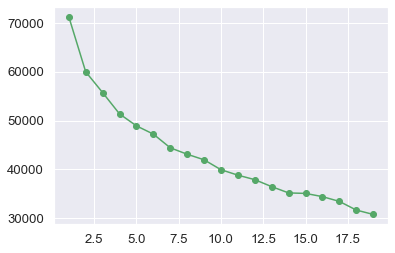

In [190]:
plt.plot(range(1,20),sse,"go-")

In [191]:
for k in range(20,41):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr_new)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 20 rounds, current sse is [71212.48569107312, 59961.0553912716, 55718.40640754076, 51358.58541956204, 48914.936879739435, 47231.55362613713, 44430.8538360807, 43116.10020242419, 41979.00457365109, 39951.827913002926, 38840.00100476354, 37918.253517250865, 36492.23667486627, 35208.24672766692, 35110.913169301835, 34451.69554221782, 33475.70635133557, 31710.85111907479, 30816.74758504079, 30245.96774744027]
have done 21 rounds, current sse is [71212.48569107312, 59961.0553912716, 55718.40640754076, 51358.58541956204, 48914.936879739435, 47231.55362613713, 44430.8538360807, 43116.10020242419, 41979.00457365109, 39951.827913002926, 38840.00100476354, 37918.253517250865, 36492.23667486627, 35208.24672766692, 35110.913169301835, 34451.69554221782, 33475.70635133557, 31710.85111907479, 30816.74758504079, 30245.96774744027, 26971.934846753244]
have done 22 rounds, current sse is [71212.48569107312, 59961.0553912716, 55718.40640754076, 51358.58541956204, 48914.936879739435, 47231.5536

have done 35 rounds, current sse is [71212.48569107312, 59961.0553912716, 55718.40640754076, 51358.58541956204, 48914.936879739435, 47231.55362613713, 44430.8538360807, 43116.10020242419, 41979.00457365109, 39951.827913002926, 38840.00100476354, 37918.253517250865, 36492.23667486627, 35208.24672766692, 35110.913169301835, 34451.69554221782, 33475.70635133557, 31710.85111907479, 30816.74758504079, 30245.96774744027, 26971.934846753244, 26875.871709024763, 26095.798893304975, 24671.031078878823, 24744.69832526802, 23238.504614599482, 23025.793633345704, 23129.04610660268, 20198.777649606833, 20037.92970100443, 19136.718972131788, 18992.564804900772, 18075.95880882376, 18968.022494496512, 18661.369597403256]
have done 36 rounds, current sse is [71212.48569107312, 59961.0553912716, 55718.40640754076, 51358.58541956204, 48914.936879739435, 47231.55362613713, 44430.8538360807, 43116.10020242419, 41979.00457365109, 39951.827913002926, 38840.00100476354, 37918.253517250865, 36492.23667486627, 

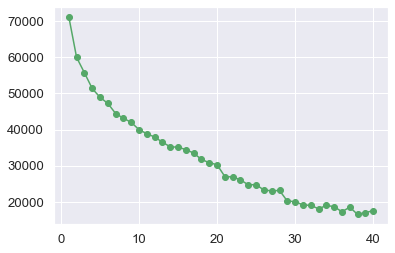

In [192]:
plt.plot(range(1,41),sse,"go-")

In [193]:
kl = KneeLocator(range(1,41), sse, curve="convex", direction="decreasing")

In [194]:
kl.elbow

13

**Using Silhouette Coefficient**

In [195]:
sc = []
new_sse = []
for k in range(2,30):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr_new)
    score = silhouette_score(ns_repr_new, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29


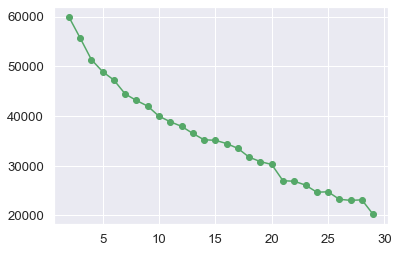

In [196]:
# for sse
plt.plot(range(2,30), new_sse, "go-")

In [197]:
kl_new = KneeLocator(range(2,30), new_sse, curve="convex", direction="decreasing")
kl_new.elbow

10

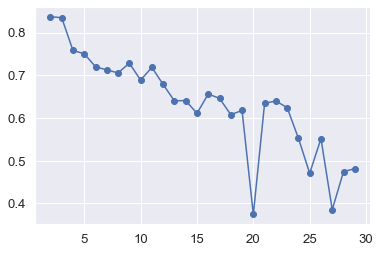

In [198]:
# for silhouette coefficient
plt.plot(range(2,30), sc, "bo-")

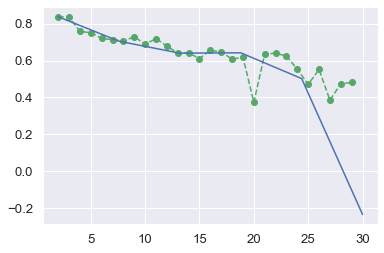

In [199]:


spl = make_interp_spline(range(2,30), sc, k=3)  # type: BSpline

xs = np.linspace(2, 30, 6)
ys = spl(xs)

plt.plot(range(2,30), sc, "go--")
plt.plot(xs, ys, "b-")

Let's choose k = 10

In [200]:
kmeans = KMeans(n_clusters = 5, init="k-means++", n_init = 50, max_iter = 500, random_state = 360)
kmeans.fit(ns_repr_new)

KMeans(max_iter=500, n_clusters=5, n_init=50, random_state=360)

In [201]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [202]:
set(kmeans.labels_)

{0, 1, 2, 3, 4}

In [203]:
Counter(kmeans.labels_)

Counter({1: 964, 2: 18, 3: 4, 0: 2, 4: 1})

**Let's investigate each cluster**

In [204]:
len(ns_sr_rep)

989

In [205]:
len(kmeans.labels_)

989

In [206]:
clustered = defaultdict(list)
for idx,ns in enumerate(non_outlier):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [207]:
print([len(clustered[i]) for i in range(5)])

[2, 964, 18, 4, 1]


Let's see in terms of percentage

In [208]:
cluster_lens = [len(clustered[i]) for i in range(10)]

In [209]:
print([round(k*100/sum(cluster_lens),2) for k in cluster_lens])

[0.2, 97.47, 1.82, 0.4, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0]


 **could do iterative clusters for ^**

In [211]:
clustered[0]

['9to5mac.com', 'macrumors.com']

# Agglomerative (Hierarchical) Clustering

In [212]:
hclustering = AgglomerativeClustering(n_clusters=5)

In [213]:
hclustering.fit(preprocessing.normalize(np.array(ns_repr_new)))

AgglomerativeClustering(n_clusters=5)

In [214]:
hclustering.labels_

array([0, 3, 4, 3, 4, 3, 1, 3, 3, 4, 1, 0, 3, 1, 3, 3, 1, 1, 3, 3, 0, 1,
       4, 3, 2, 3, 1, 3, 3, 3, 3, 2, 3, 3, 3, 4, 3, 0, 3, 3, 1, 1, 3, 3,
       1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3,
       0, 3, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 0,
       1, 0, 1, 1, 3, 3, 0, 1, 1, 3, 3, 3, 3, 3, 3, 0, 2, 3, 1, 3, 3, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 0, 3, 3, 3, 2, 3, 1, 0, 3, 3, 4,
       3, 2, 0, 0, 3, 3, 0, 3, 3, 0, 3, 1, 1, 2, 3, 4, 3, 1, 3, 1, 0, 3,
       3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 4, 3, 3, 0, 3, 1, 3, 3, 0, 3, 0, 1,
       3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 3, 0, 3, 3, 3, 3, 0, 1, 3,
       3, 1, 1, 1, 1, 3, 4, 3, 1, 0, 3, 3, 3, 1, 3, 1, 3, 3, 3, 0, 3, 3,
       3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 2, 1, 1, 3, 1, 0, 0, 0, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 4, 3, 2, 2, 3, 3, 3, 1, 2, 0, 2, 1, 0, 3, 3, 3, 1,
       3, 3, 3, 3, 1, 3, 1, 0, 2, 3, 3, 1, 3, 3, 3, 3, 2, 1, 1, 3, 1, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 0, 3, 2,

In [215]:
hier_clustered = defaultdict(list)
for idx,ns in enumerate(non_outlier):
    c = hclustering.labels_[idx]
    hier_clustered[c].append(ns)

In [216]:
print([len(hier_clustered[i]) for i in range(5)])

[117, 200, 70, 575, 27]


Let's see in terms of percentage

In [217]:
hcluster_lens = [len(hier_clustered[i]) for i in range(10)]

In [218]:
print([round(k*100/sum(hcluster_lens),2) for k in hcluster_lens])

[11.83, 20.22, 7.08, 58.14, 2.73, 0.0, 0.0, 0.0, 0.0, 0.0]


In [227]:
hier_clustered[5]

[]

In [220]:
set(hier_clustered[0]) & set(clustered[4])

{'theverge.com'}

## Using scipy

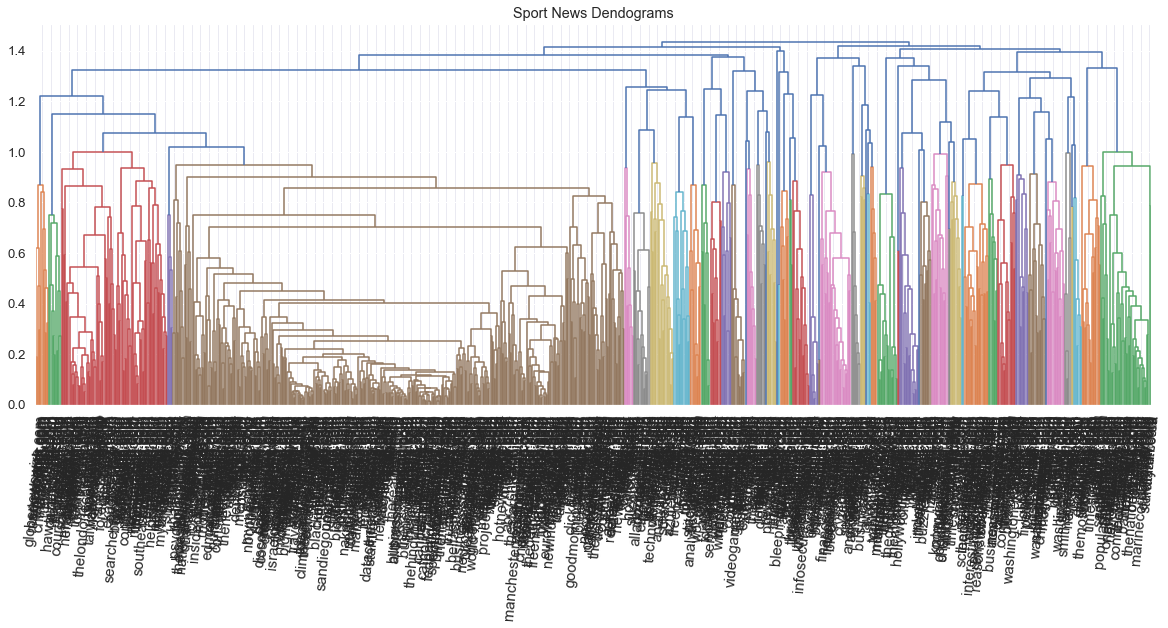

In [221]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(20, 7))
plt.title("Sport News Dendograms")
dend = shc.dendrogram(shc.linkage(preprocessing.normalize(np.array(ns_repr_new)), method='weighted'),
# dend = shc.dendrogram(shc.linkage(StandardScaler().fit_transform(np.array(ns_repr_new)), method='weighted'),
                     labels = list(ns_sr_rep.keys()),
                     leaf_font_size = 15,
                     leaf_rotation = 85)

In [277]:
"foxnews.com" in ns_union

True

## Visualizing 2D PCA

In [278]:
twodpca = PCA(n_components=4)

In [279]:
fit2 = twodpca.fit_transform(preprocessing.normalize(np.array(ns_repr)))

In [280]:
x = [k[0] for k in fit2]
y = [k[1] for k in fit2]
z = [k[2] for k in fit2]
a = [k[3] for k in fit2]

In [281]:
# ?px.scatter_3d

In [282]:
import plotly.express as px
import pandas

ns_fixed = list(ns_sr_rep.keys())

df = pandas.DataFrame({"pc1": x,
                   "pc2": y,
                   "pc3": z,
                   "pc4": a,
                   "source": ns_fixed})

fig = px.scatter_3d(df, x='pc1', y='pc2', z='pc3', color='pc4', hover_name='source', opacity=0.4)
fig.show()

With t-SNE

In [283]:
from sklearn.manifold import TSNE
from datetime import datetime

tsne = TSNE(n_components = 3, perplexity=50)

In [284]:
print(datetime.now())
threed = tsne.fit_transform(old_ns_repr_new)
print(datetime.now())

2022-03-31 09:06:19.362896
2022-03-31 09:06:19.854826


In [285]:
xs = [k[0] for k in threed]
ys = [k[1] for k in threed]
zs = [k[2] for k in threed]

In [286]:
df = pandas.DataFrame({"pc1": xs,
                   "pc2": ys,
                   "pc3": zs,
                   # "pc4": bs[:100],
                   "source": ns_fixed})

fig = px.scatter_3d(df, x='pc1', y='pc2', z='pc3', 
                    # color='pc4', 
                    hover_name='source', opacity=0.4)
fig.show()

In [191]:
from sklearn import metrics

In [192]:
metrics.silhouette_score(ns_repr_new, kmeans.labels_, metric='euclidean')

0.6572416420678999

In [193]:
# higher better
metrics.calinski_harabasz_score(ns_repr_new, kmeans.labels_)

72.30732206294617

In [194]:
# closer to 0 better
metrics.davies_bouldin_score(ns_repr_new, kmeans.labels_)

0.5856989016710585